In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from modules.multitask import *

# plt.rcParams['axes.grid'] = False
# plt.rcParams['xtick.labelsize'] = False
# plt.rcParams['ytick.labelsize'] = False
# plt.rcParams['axes.labelsize'] = False
# plt.rcParams['figure.figsize'] = [10, 10]
%load_ext autoreload
%autoreload 2

In [2]:
checkpoint = torch.load("/home/avagr/ViT/models/EMNIST-24_encoder_240-762-6-aux-sin-2cls_best.pt")
encoder_model = EncoderBUTD(
    4, 47, 47, enc_config=ViTConfig(hidden_size=240, num_hidden_layers=6,
                                    intermediate_size=768, num_channels=1,
                                    patch_size=16, num_attention_heads=12,
                                    image_size=(224, 224)),
    use_sinusoidal=True,
    aux_head_size=47
)
encoder_model.load_state_dict(checkpoint)
encoder_model.cuda();

ןכ

In [3]:
from modules.multitask import MixingBUTD

checkpoint = torch.load("/home/avagr/ViT/models/EMNIST-24_mixing_192-512-3-aux-sin-2cls_last.pt")['model_state_dict']
mixing_model = MixingBUTD(
    4, 47, 47, config=ViTConfig(hidden_size=192, num_hidden_layers=3,
                                intermediate_size=512, num_channels=1,
                                patch_size=16, num_attention_heads=12,
                                image_size=(224, 224), ),
    use_sinusoidal=False, use_self_attention=True, stretch=False,
    aux_head_size=47, total_token_size=198 * 192, mix_with='q'
)
mixing_model.load_state_dict(checkpoint)
mixing_model.cuda()

checkpoint = torch.load("/home/avagr/ViT/models/EMNIST-24_enc-dec_240-762-240-762-3-aux-sinusoidal_best.pt")
encdec_model = EncDecBUTD(
    4, 47, 47, enc_config=ViTConfig(hidden_size=240, num_hidden_layers=3,
                                    intermediate_size=762, num_channels=1,
                                    patch_size=16, num_attention_heads=12,
                                    image_size=(224, 224), ),
    dec_config=ViTConfig(hidden_size=240, num_hidden_layers=3,
                         intermediate_size=762, num_channels=1,
                         patch_size=16, num_attention_heads=12,
                         image_size=(224, 224), ),
    use_sinusoidal=False,
    aux_head_size=47, use_butd=False
)
encdec_model.load_state_dict(checkpoint)
encdec_model.cuda();

In [4]:
ABOVE = torch.tensor([1., 0., 0., 0., ], device="cuda").unsqueeze(0)
BELOW = torch.tensor([0., 1., 0., 0., ], device="cuda").unsqueeze(0)
RIGHT_OF = torch.tensor([0., 0., 1., 0., ], device="cuda").unsqueeze(0)
LEFT_OF = torch.tensor([0., 0., 0., 1., ], device="cuda").unsqueeze(0)
cls_to_chr: {int: str} = {}

with open("../datasets/emnist-balanced-mapping.txt", 'r') as ipt:
    for line in ipt:
        a, b = line.split()
        cls_to_chr[int(a)] = chr(int(b))

chr_to_cls = {v: torch.nn.functional.one_hot(torch.tensor(k, device="cuda"), 47).float().unsqueeze(0) for k, v in
              cls_to_chr.items()}

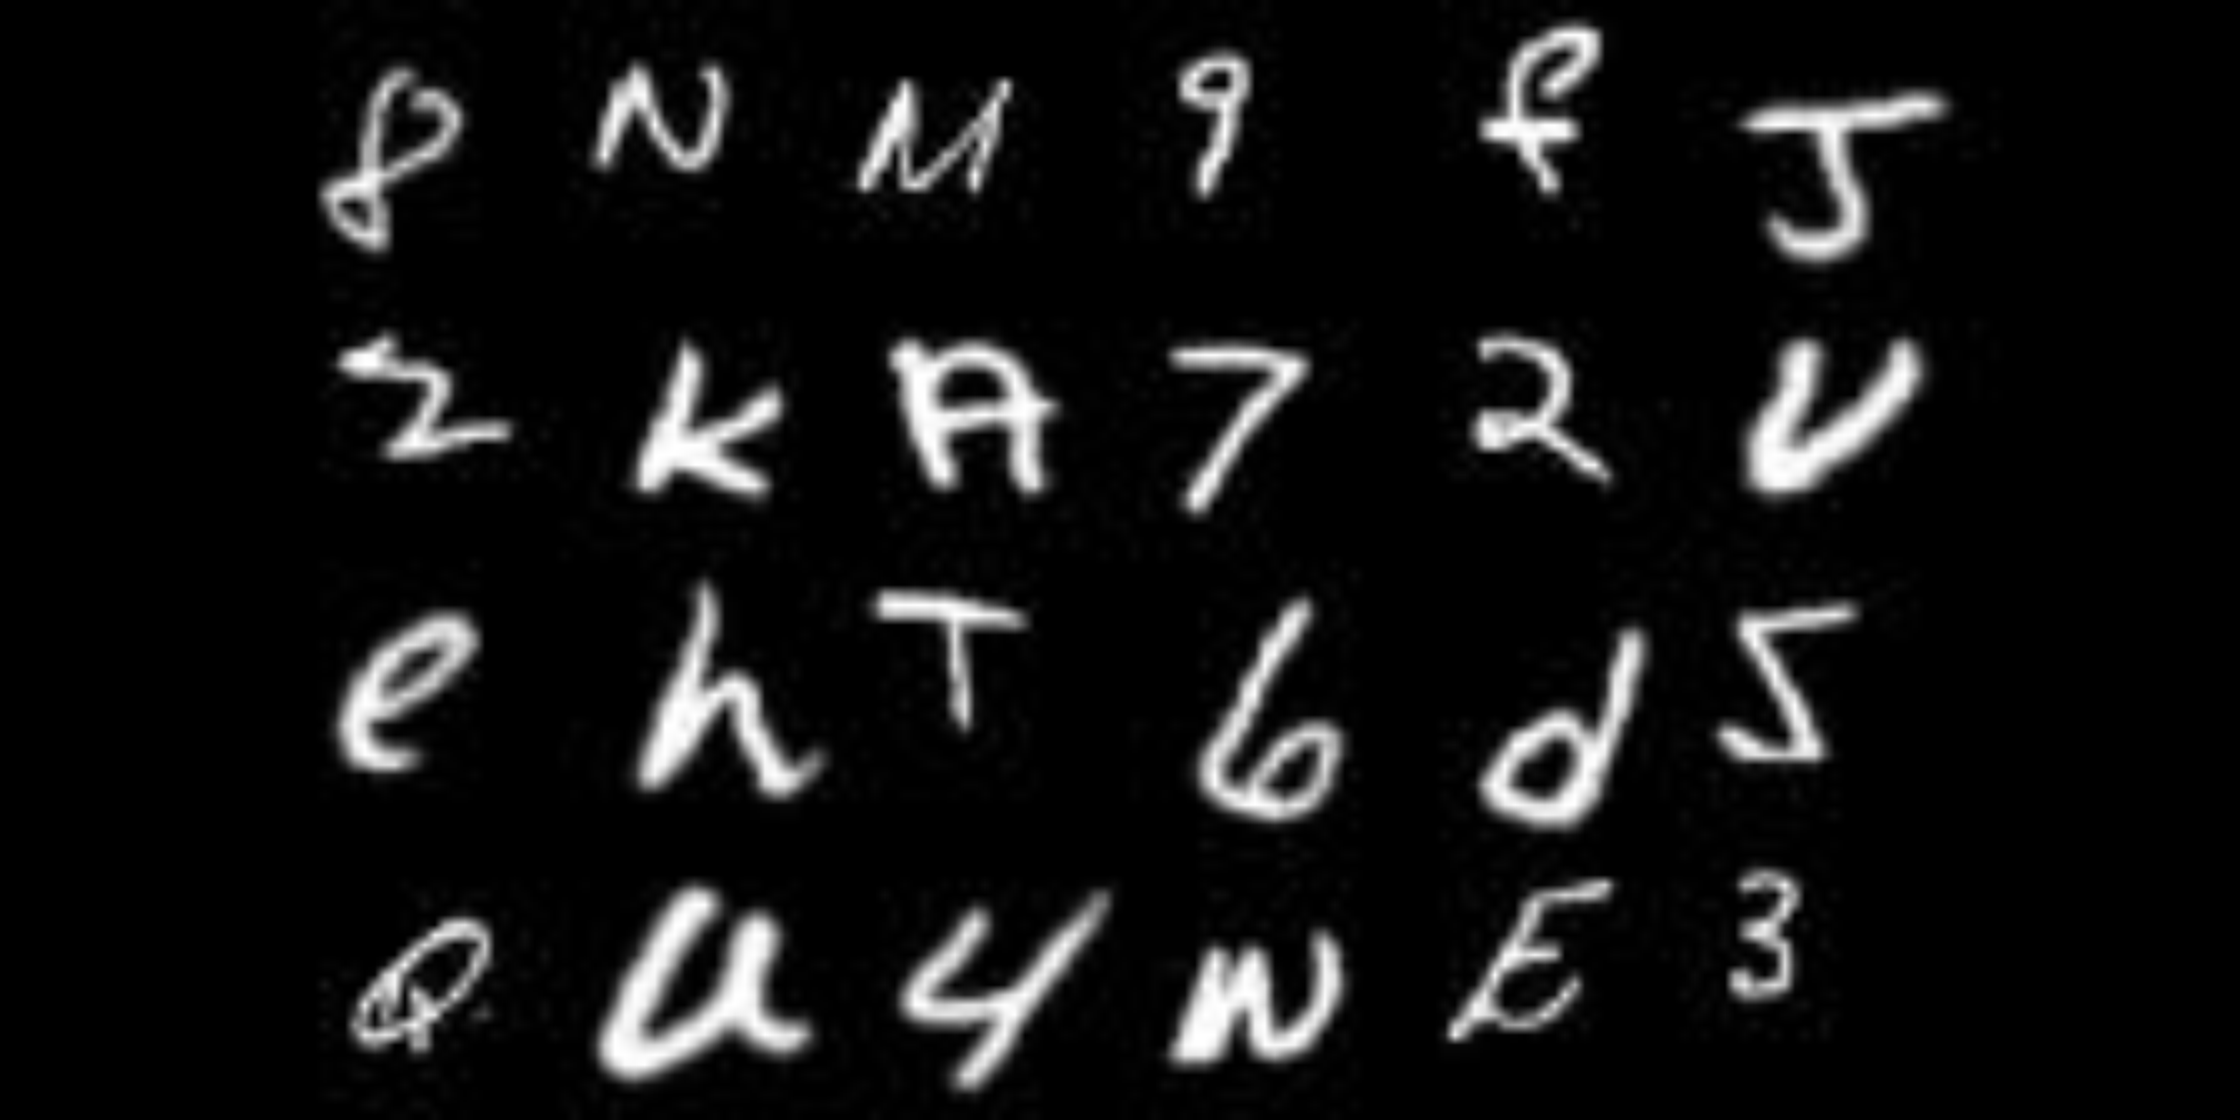

In [77]:
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[0].view(1, 1, 224, 224).cuda())
])
# val_dataset = Emnist24Directions("/home/avagr/ViT/emnist-24/emnist/samples/24_sufficient1/val", 47, transform=transform)


img = Image.open("/home/avagr/ViT/emnist-24/emnist/samples/24_sufficient1/val/0/0_img.jpg")
transforms.Resize((1120, 2240))(img)

In [74]:
directions = [ABOVE, BELOW, RIGHT_OF, LEFT_OF]
encoder_embeddings = [encoder_model.task_embeddings(d) for d in directions]
mixing_embeddings = [mixing_model.task_embeddings(d) for d in directions]
encdec_embeddings = [encdec_model.task_embeddings(d) for d in directions]

/tmp/ipykernel_16757/2172946594.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), fontweight='bold')


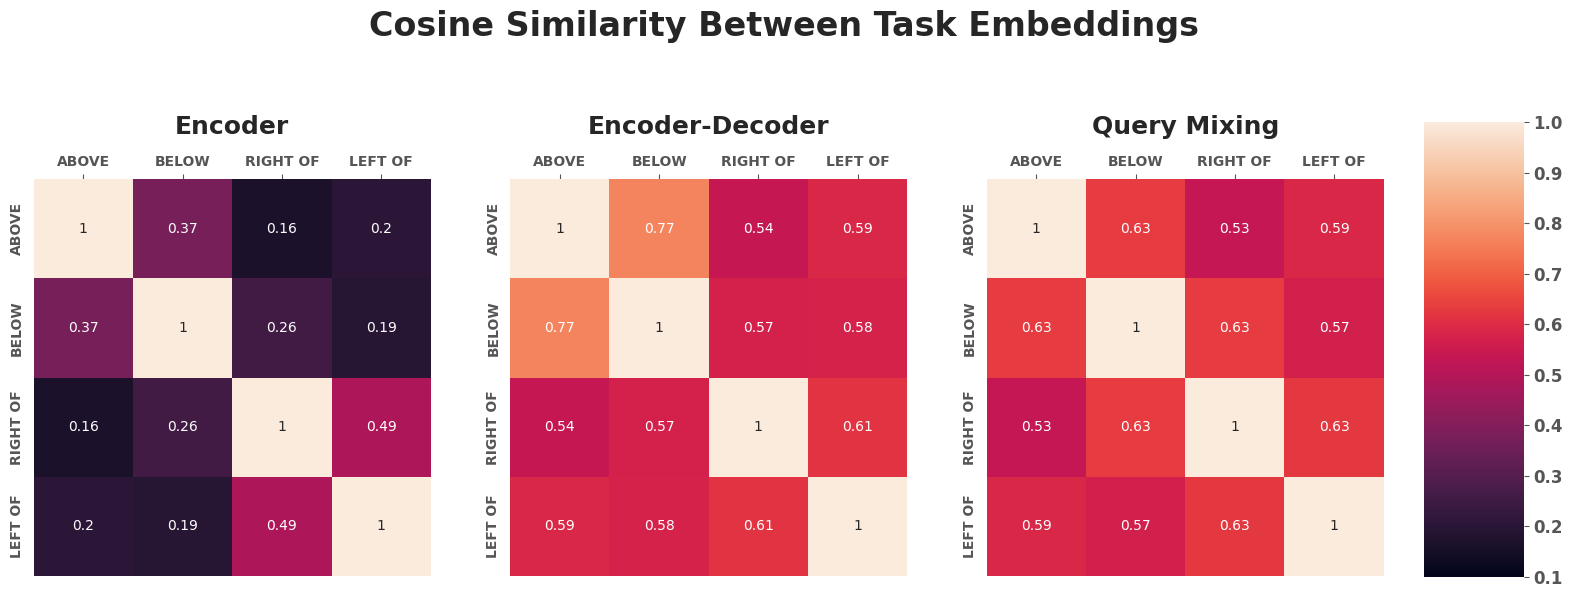

In [85]:
# Function to plot the cosine similarity matrix from the embeddings
def plot_similarity_matrix(embeddings, title, ax, cbar_ax):
    cos = torch.nn.CosineSimilarity(dim=-1)
    sim_mat = torch.stack([cos(embeddings[i], embeddings[j]) for i in range(len(embeddings)) for j in range(len(embeddings))]).view(len(embeddings), len(embeddings))
    sns.heatmap(sim_mat.cpu().detach().numpy(), annot=True, xticklabels=['ABOVE', 'BELOW', 'RIGHT OF', 'LEFT OF'], yticklabels=['ABOVE', 'BELOW', 'RIGHT OF', 'LEFT OF'], ax=ax, cbar_ax=cbar_ax, vmin=0.1, vmax=1, cmap= 'rocket')
    # set xticks to be above
    ax.xaxis.tick_top()
    # Set all text to be bold
    ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
    # Set colorbar text to be bold
    cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), fontweight='bold')

    # Set the title of the subplot with bigger fontsize and centered position above the plot
    ax.set_title(title, fontsize=18, fontweight='bold', pad=15)

# Set plotting style to ggplot
plt.style.use('ggplot')

# Plot a 3x1 grid of similarity matrices
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
# Force each plot to be square
for ax in axs:
    ax.set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.21, 0.05, 0.65])
cbar_ax.tick_params(labelsize=12)
# add a colorbar

plot_similarity_matrix(encoder_embeddings, 'Encoder', axs[0], cbar_ax)
plot_similarity_matrix(encdec_embeddings, 'Encoder-Decoder', axs[1], cbar_ax)
plot_similarity_matrix(mixing_embeddings, 'Query Mixing', axs[2], cbar_ax)
# Plot one single colorbar with the same height as the plots


# fig.colorbar(axs[0].get_children()[0], cax=cbar_ax)
fig.suptitle('Cosine Similarity Between Task Embeddings', fontsize=24, fontweight='bold', y=1.02)

plt.show()
# Export the plot as a pdf
fig.savefig('task_embeddings_similarity.pdf', bbox_inches='tight')

/tmp/ipykernel_16757/2172946594.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), fontweight='bold')


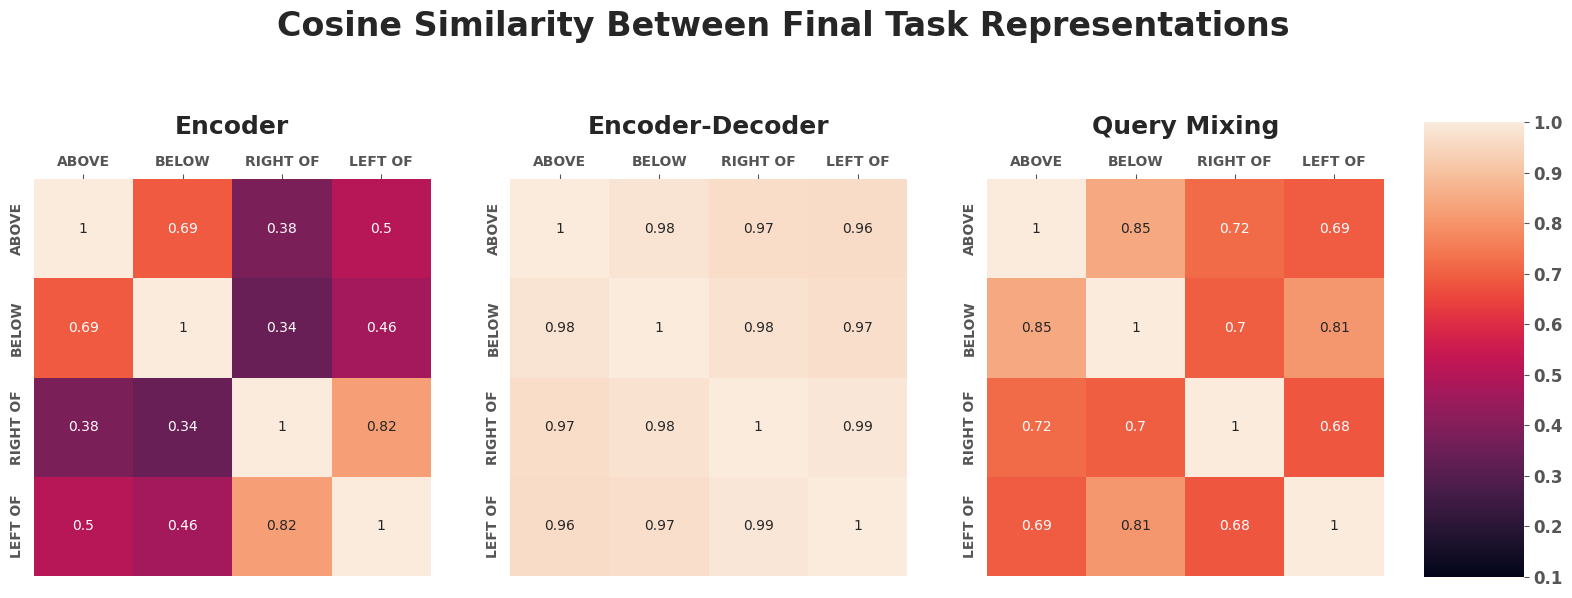

In [81]:
final_encoder_embeddings = [encoder_model(transform(img), d, chr_to_cls['J'], output_task_tokens=True)[2] for d in directions]
final_mixing_embeddings = [mixing_model(transform(img), d, chr_to_cls['J'], output_task_tokens=True)[2] for d in directions]
final_encdec_embeddings = [encdec_model(transform(img), d, chr_to_cls['J'], output_task_tokens=True)[2] for d in directions]

# Plot a 3x1 grid of similarity matrices
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
# Force each plot to be square
for ax in axs:
    ax.set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.21, 0.05, 0.65])
cbar_ax.tick_params(labelsize=12)
# add a colorbar

plot_similarity_matrix(final_encoder_embeddings, 'Encoder', axs[0], cbar_ax)
plot_similarity_matrix(final_encdec_embeddings, 'Encoder-Decoder', axs[1], cbar_ax)
plot_similarity_matrix(final_mixing_embeddings, 'Query Mixing', axs[2], cbar_ax)
# Plot one single colorbar with the same height as the plots


# fig.colorbar(axs[0].get_children()[0], cax=cbar_ax)
fig.suptitle('Cosine Similarity Between Final Task Representations', fontsize=24, fontweight='bold', y=1.02)

plt.show()
# Export the plot as a pdf
fig.savefig('task_final_repr_similarity.pdf', bbox_inches='tight')

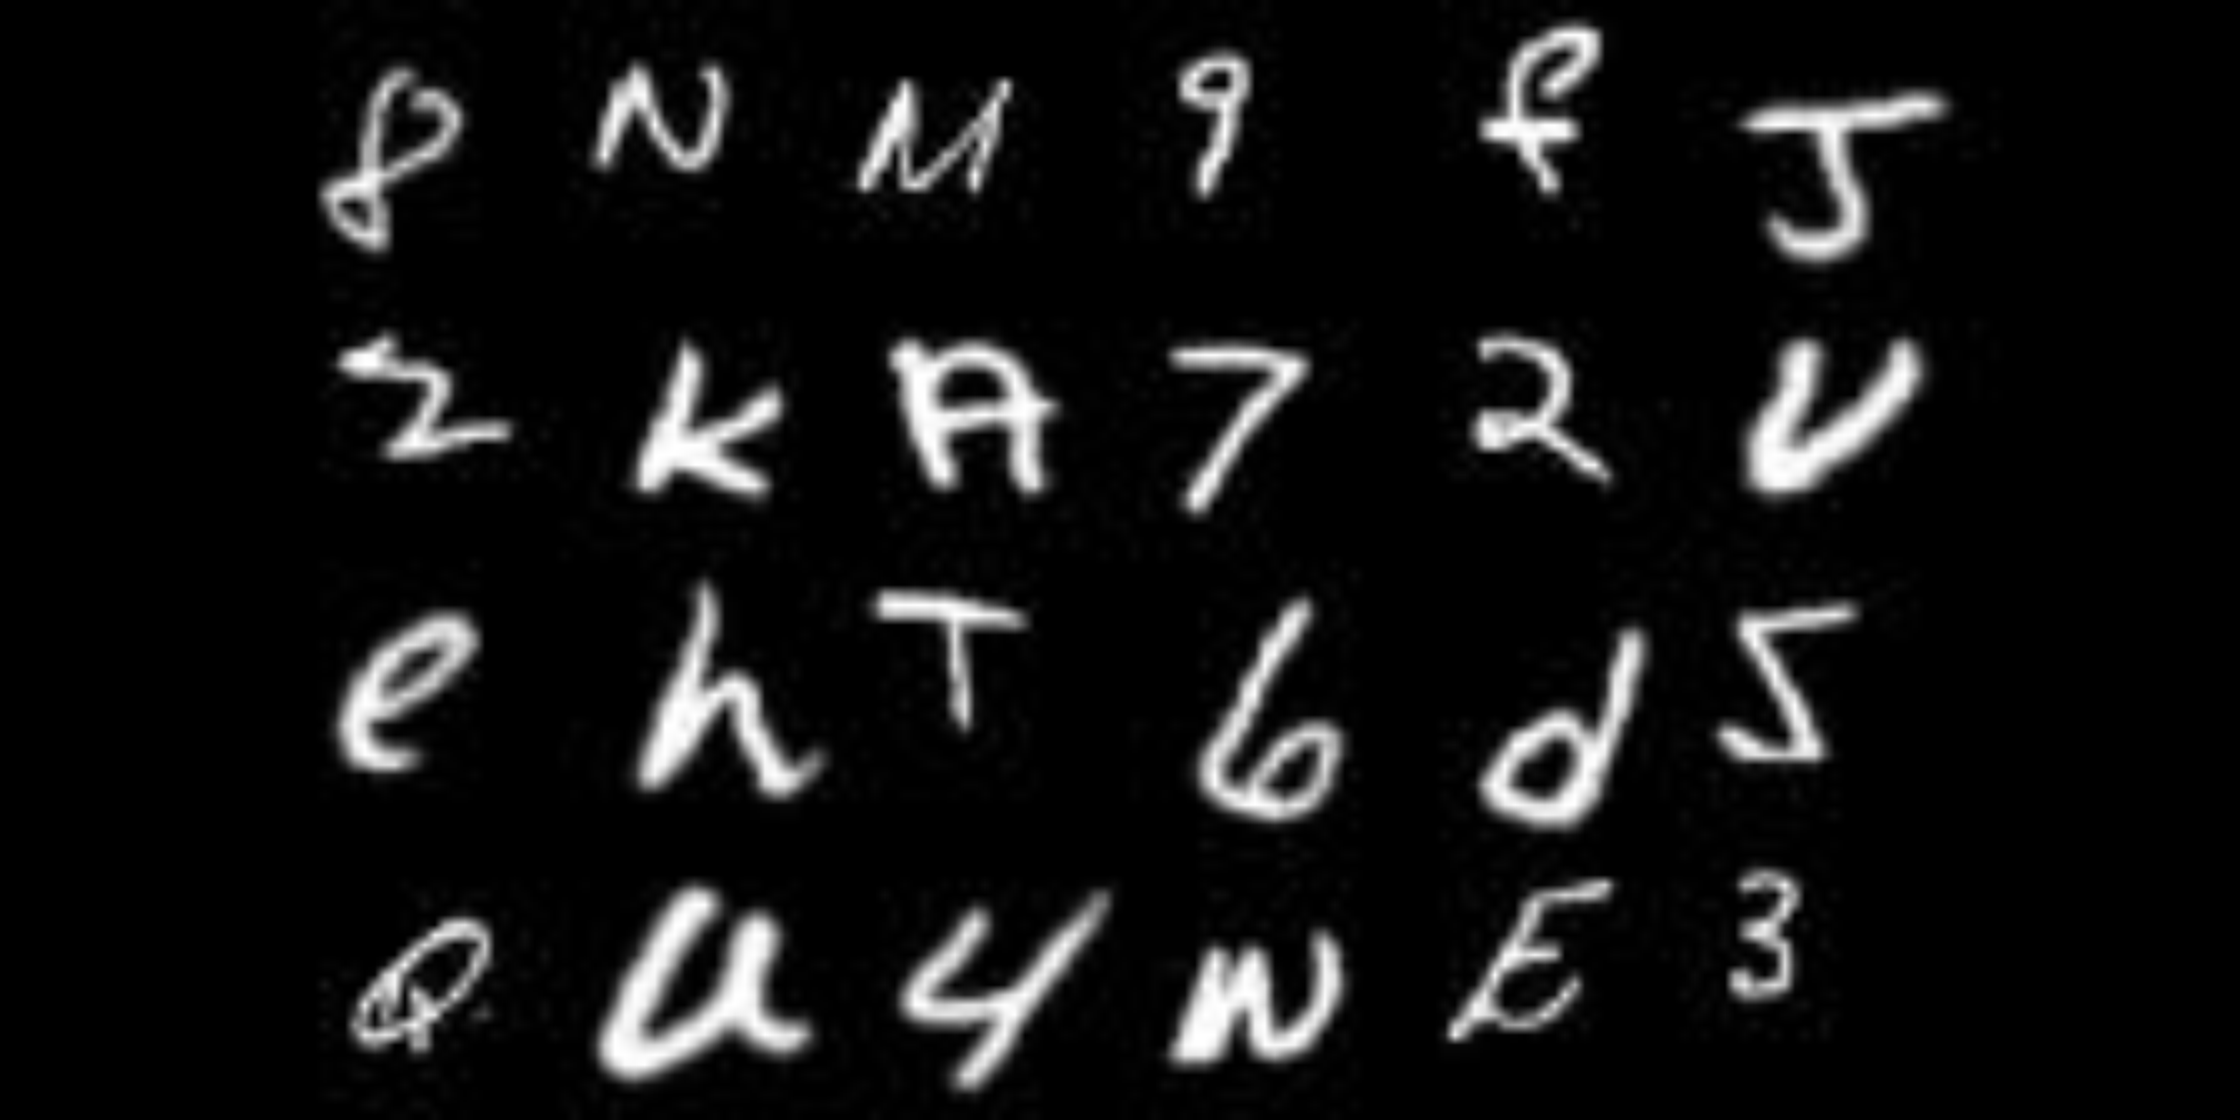

In [82]:
res = dir_model(transform(img), BELOW, chr_to_cls['K'], True)
predictions = res[0].cpu().detach()
cls_to_chr[torch.argmax(predictions).item()]

'h'

Text(0.5, 1.03, 'Encoder Attention Rollout Visualization')

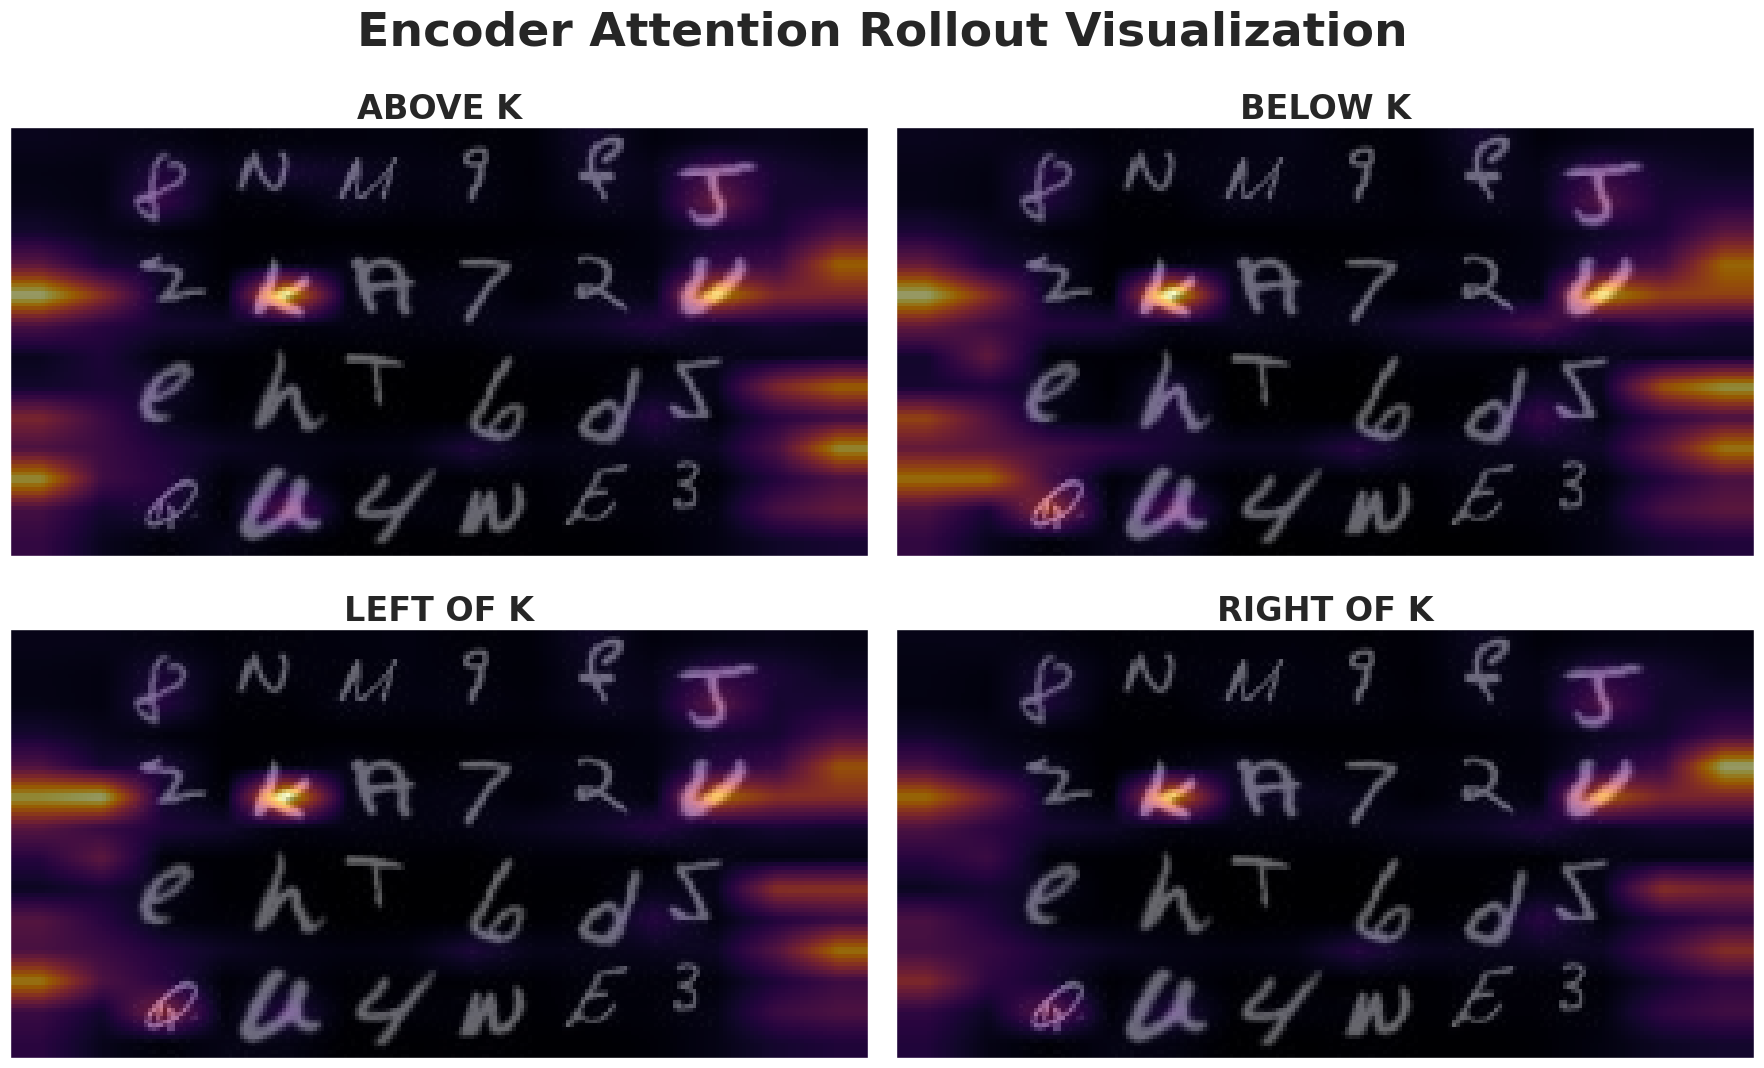

In [138]:
import cv2
import numpy as np


def attention_rollout_map(attention_tuple, select_head=None):
    if select_head is None:
        attn_mat = torch.stack(attention_tuple, dim=0).squeeze().mean(dim=1).detach().cpu()
    else:
        attn_mat = torch.stack(attention_tuple, dim=0).squeeze()[:, select_head, :, :].detach().cpu()
    aug_attn_mat = attn_mat + torch.eye(attn_mat.shape[1])
    aug_attn_mat = aug_attn_mat / torch.sum(aug_attn_mat, dim=-1)[..., None]
    aug_attn_mat = aug_attn_mat.numpy()

    # Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, 4:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), (224, 112))[..., np.newaxis]
    return mask


def visualize_rollout(model, img, task, arg, transform, ax, select_head=None, ):
    _, _, att = model(transform(img), task, arg, True)
    mask = attention_rollout_map(att, select_head).squeeze()
    ax.imshow(img)
    ax.imshow(mask, cmap="inferno", alpha=0.6)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

# Disable the grid and the ticks in the plot


# visualize_rollout(encoder_model, img, ABOVE, chr_to_cls['K'], transform, plt.gca())

# Create a 2x2 grid of plots visualizing the rollout for all task inputs
fig, axs = plt.subplots(2, 2, figsize=(18, 11))
# Plot the rollout for each task input
for i, task in enumerate([ABOVE, BELOW, LEFT_OF, RIGHT_OF]):
    visualize_rollout(encoder_model, img, task, chr_to_cls['K'], transform, axs[i // 2, i % 2], select_head=10)
# Add padding between the plots
fig.tight_layout(pad=2)
# Set captions
axs[0, 0].set_title('ABOVE K', fontsize=24, fontweight='bold')
axs[0, 1].set_title('BELOW K', fontsize=24, fontweight='bold')
axs[1, 0].set_title('LEFT OF K', fontsize=24, fontweight='bold')
axs[1, 1].set_title('RIGHT OF K', fontsize=24, fontweight='bold')
plt.suptitle('Encoder Attention Rollout Visualization', fontsize=34, fontweight='bold', y=1.03)
# Export the plot as a pdf
# fig.savefig('rollout.png', bbox_inches='tight', dpi=400)

In [8]:
batch = torch.stack([RIGHT_OF, LEFT_OF, ABOVE, BELOW], dim=0)
mean_task = dir_model.task_embeddings(batch).mean(dim=0)
torch.norm(dir_model.task_embeddings(batch), dim=-1)

tensor([[9.0637],
        [8.5629],
        [9.4969],
        [8.2768]], device='cuda:0', grad_fn=<NormBackward1>)

In [151]:
from modules.multitask import MixingBUTD

checkpoint = torch.load("/home/avagr/ViT/models/EMNIST-24_mixing_192-512-3-aux-sin-2cls_last.pt")['model_state_dict']
mixing_model = MixingBUTD(
    4, 47, 47, config=ViTConfig(hidden_size=192, num_hidden_layers=3,
                                intermediate_size=512, num_channels=1,
                                patch_size=16, num_attention_heads=12,
                                image_size=(224, 224), ),
    use_sinusoidal=False, use_self_attention=True, stretch=False,
    aux_head_size=47, total_token_size=198 * 192, mix_with='q'
)
mixing_model.load_state_dict(checkpoint)
mixing_model.cuda();

In [151]:
from modules.multitask import EncoderBUTD

checkpoint = torch.load("/home/avagr/ViT/models/EMNIST-24_encoder_240-762-6-aux-sin-2cls_best.pt")
encoder_model = EncoderBUTD(
    4, 47, 47, enc_config=ViTConfig(hidden_size=240, num_hidden_layers=6,
                                    intermediate_size=762, num_channels=1,
                                    patch_size=16, num_attention_heads=12,
                                    image_size=(224, 224), ),
    use_sinusoidal=False,
    aux_head_size=47,
)
mixing_model.load_state_dict(checkpoint)
mixing_model.cuda();

In [151]:
from modules.multitask import MixingBUTD

checkpoint = torch.load("/home/avagr/ViT/models/EMNIST-24_mixing_192-512-3-aux-sin-2cls_last.pt")['model_state_dict']
mixing_model = MixingBUTD(
    4, 47, 47, config=ViTConfig(hidden_size=192, num_hidden_layers=3,
                                intermediate_size=512, num_channels=1,
                                patch_size=16, num_attention_heads=12,
                                image_size=(224, 224), ),
    use_sinusoidal=False, use_self_attention=True, stretch=False,
    aux_head_size=47, total_token_size=198 * 192, mix_with='q'
)
mixing_model.load_state_dict(checkpoint)
mixing_model.cuda();

torch.Size([12, 198, 16])


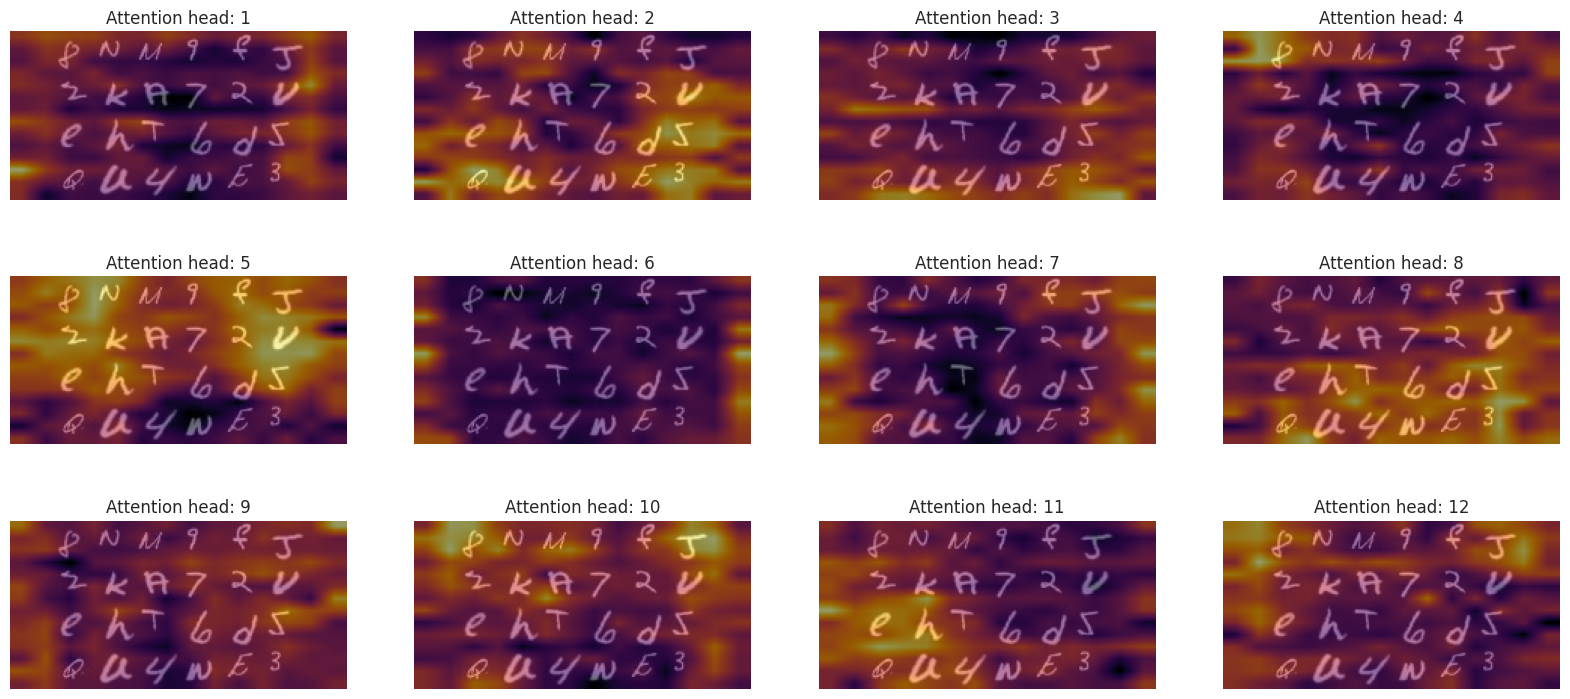

In [175]:
def attention_heatmap(attention_scores):
    grid_size = 14
    # mask = attention_scores[0, 3, 0, 4:].reshape(grid_size, grid_size).cpu().detach()
    # mask = mask.expand(12, -1, -1).numpy()
    print(attention_scores.shape)
    # mask = attention_scores[0, :, 0, 2:].reshape(attention_scores.shape[1], grid_size, grid_size).cpu().detach().numpy()
    mask = attention_scores.mean(dim=-1)[:, 2:].reshape(12, grid_size, grid_size).cpu().detach().numpy()
    mask = mask.transpose(1, 2, 0)
    mask = cv2.resize(mask / mask.max(), (224, 112))
    return mask


def visualize_heads(model, img, task, arg, transform, layer=3):
    _, _, att = model(transform(img), task, arg, True)
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 9))
    masks = attention_heatmap(torch.cat(att, dim=0).mean(0))

    for i in range(3):
        for j in range(4):
            axes[i, j].imshow(img)
            axes[i, j].imshow(masks[:, :, i * 4 + j], cmap="inferno", alpha=0.6)

            axes[i, j].title.set_text(f"Attention head: {i * 4 + j + 1}")
            axes[i, j].axis("off")
    plt.show()


visualize_heads(mixing_model, img, ABOVE, chr_to_cls['K'], transform, layer=3)

torch.Size([1, 12, 198, 16])


RuntimeError: shape '[12, 14, 14]' is invalid for input of size 168

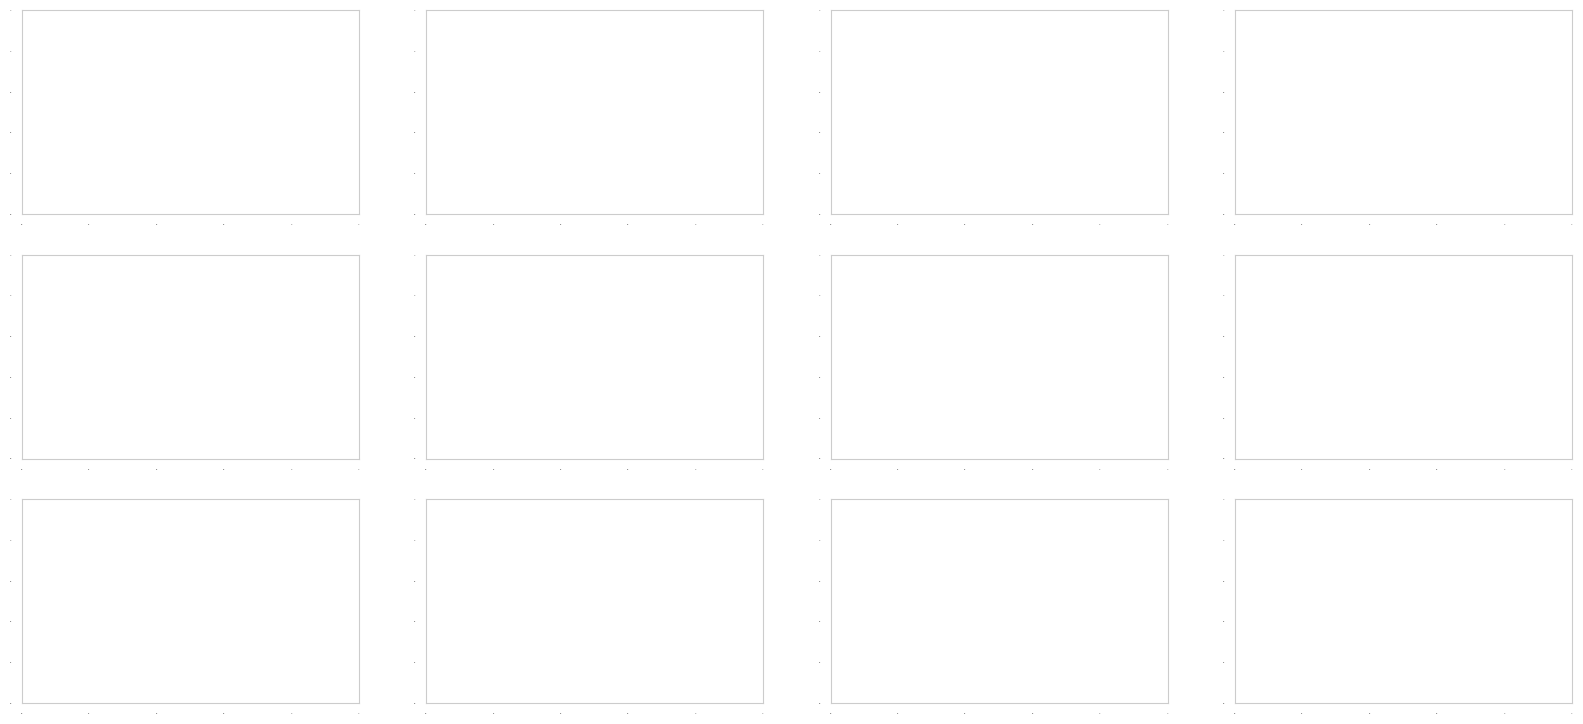

In [ ]:
above_vec = dir_model.task_embeddings(ABOVE)
below_vec = dir_model.task_embeddings(BELOW)
right_vec = dir_model.task_embeddings(RIGHT_OF)
left_vec = dir_model.task_embeddings(LEFT_OF)

# Compute normalized embedding vectors
above_vec = above_vec / torch.norm(above_vec)
below_vec = below_vec / torch.norm(below_vec)
right_vec = right_vec / torch.norm(right_vec)
left_vec = left_vec / torch.norm(left_vec)

matr = torch.stack([above_vec, below_vec, right_vec, left_vec], dim=0).squeeze()
# Compute a square matrix of cosine similarities
matr = torch.mm(matr, matr.t())

sns.heatmap(matr.cpu().detach().numpy(), annot=True, xticklabels=["above", "below", "right", "left"],
            yticklabels=["above", "below", "right", "left"])
plt.show()

In [ ]:
arg_embeddings = {k: dir_model.argument_embeddings(v).detach().cpu().squeeze() for k, v in chr_to_cls.items()}

# Fit TSNE to the embeddings
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=5000, verbose=1)
tsne_results = tsne.fit_transform(torch.stack(list(arg_embeddings.values())).numpy())

# Set matplotlib style to ggplot
plt.style.use('ggplot')

# Plot the TSNE visualization of each embedding from dict with keys instead of dots on the scatterplot
plt.figure(figsize=(20, 20))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], color="none")
for i, txt in enumerate(list(arg_embeddings.keys())):
    plt.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]))
plt.show()